## Titanic Dataset Overview

The Titanic dataset contains information about passengers aboard the Titanic, including survival status, demographics, and travel details. It has **891 rows** and **12 columns**.

### Data Dictionary

| Variable | Definition | Key/Notes |
|----------|------------|-----------|
| **PassengerId** | Unique identifier for each passenger | `int64` |
| **Survived** | Survival status | `0 = No, 1 = Yes` |
| **Pclass** | Ticket class | `1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower)`<br>A proxy for socio-economic status (SES) |
| **Name** | Passenger's name | `object` |
| **Sex** | Sex | `male, female` |
| **Age** | Age in years | `float64`<br>• Age is fractional if less than 1<br>• Estimated ages are in the form xx.5 |
| **SibSp** | Number of siblings/spouses aboard | `int64`<br>• Sibling = brother, sister, stepbrother, stepsister<br>• Spouse = husband, wife (mistresses and fiancés were ignored) |
| **Parch** | Number of parents/children aboard | `int64`<br>• Parent = mother, father<br>• Child = daughter, son, stepdaughter, stepson<br>• Some children traveled only with a nanny (parch=0) |
| **Ticket** | Ticket number | `object` |
| **Fare** | Passenger fare | `float64` |
| **Cabin** | Cabin number | `object` |
| **Embarked** | Port of embarkation | `C = Cherbourg, Q = Queenstown, S = Southampton` |

### Dataset Characteristics
- **Total passengers**: 891 (sample of the actual 2,224 passengers and crew)
- **Missing values**: 
	- Age: 177 missing (714 non-null)
	- Cabin: 687 missing (204 non-null)
	- Embarked: 2 missing (889 non-null)
- **Target variable**: `Survived` (binary classification)
- **Key features**: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked

The sinking of the RMS Titanic on April 15, 1912, during her maiden voyage is one of the most infamous maritime disasters in history. The "unsinkable" ship collided with an iceberg, resulting in the deaths of 1,502 out of 2,224 passengers and crew. The tragedy was exacerbated by insufficient lifeboats, leading to survival being influenced by factors beyond mere chance.

### The Analytical Challenge
This dataset presents an opportunity to build a predictive model that answers the fundamental question: **"What sorts of people were more likely to survive the Titanic disaster?"**

By analyzing passenger attributes such as:
- Socio-economic status (via Pclass)
- Gender and age demographics
- Family size (SibSp + Parch)
- Travel details (fare, embarkation port)

We can uncover patterns in survival likelihood and build models that predict survival outcomes based on passenger characteristics. This serves as a classic binary classification problem in machine learning, combining historical analysis with predictive modeling techniques.

In [1]:
from __future__ import annotations

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from typing import Literal

from numpy.typing import ArrayLike
from scipy.stats import loguniform, uniform
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


## Loading the Train Dataset from GitHub

The training dataset is loaded directly from the GitHub repository, making it easily accessible from any environment (Colab, Kaggle, local machine, etc.). This approach eliminates the need to manually download the CSV file and ensures reproducibility across different platforms.

In [4]:
train_url = "https://raw.githubusercontent.com/jhlopesalves/classic_workflows/refs/heads/main/supervised_learning/classification/titanic/data/train.csv"
train = pd.read_csv(train_url)

### Basic Inspection of the Data

In [5]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
train.shape

(891, 12)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Exploratory Data Analysis (EDA)

1. **Feature Distributions**: Examine how passengers are distributed across categorical variables (Sex, Passenger Class, Embarkation Port, Parental/Child Relations)
2. **Survival Patterns**: Analyze survival rates across different demographic and socio-economic groups
3. **Age Analysis**: Explore age distributions and their relationship with survival outcomes
4. **Cabin Information**: Investigate the impact of cabin availability on survival likelihood
5. **Missing Data**: Develop strategies for handling missing values in Age and other columns

In [8]:
# Missingness
train.isna().sum().sort_values(ascending=False)

,0
Cabin,687
Age,177
Embarked,2
PassengerId,0
Name,0
Pclass,0
Survived,0
Sex,0
Parch,0
SibSp,0


### Basic Plots 

In [9]:
# Enables Seaborn to use matplotlib colour codes
sns.set_color_codes("bright")

### Ad hoc Transformations and Data Preparation

In this section, we perform custom transformations and modifications to prepare the data for analysis and visualization:

- **Feature Engineering**: Create new derived features from existing columns (e.g., cabin prefix extraction, missing value indicators);
- **Data Mapping**: Convert categorical codes to human-readable labels for better interpretability;
- **Missing Value Handling**: Develop strategies for imputing missing values in Age and Cabin columns;
- **Data Visualization**: Generate plots and charts to uncover patterns and relationships in survival outcomes;
- **Exploratory Insights**: Extract actionable insights from the transformed data to inform feature engineering and modeling decisions.

In [10]:
train_raw = train.copy()
train_eda = train_raw.copy()
# Maps Pclass to intuitive/readable values
train_eda["Pclass"] = train_eda["Pclass"].map({1: "1st (Upper)", 2: "2nd (Middle)", 3: "3rd (Lower)"})
# Maps Embarked Acronyms to the actual names of the cities
train_eda["Embarked"] = train_eda["Embarked"].map({"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"})
# Extracts the prefix of the Cabin codes (it seems to be the only meaningful unit on the cabin codes)
train_eda["CabinCode"] = train_eda["Cabin"].str[0]
# Creates a binary indicator for the missingness on the 'Cabin' column
train_eda["CabinMissing"] = np.where(train_eda["CabinCode"].isna(), "Missing", "Non-missing")
# Creates a binary indicator for the missingness on the 'Age' column
train_eda["AgeMissing"] = np.where(train_eda["Age"].isna(), "Missing", "Non-missing")

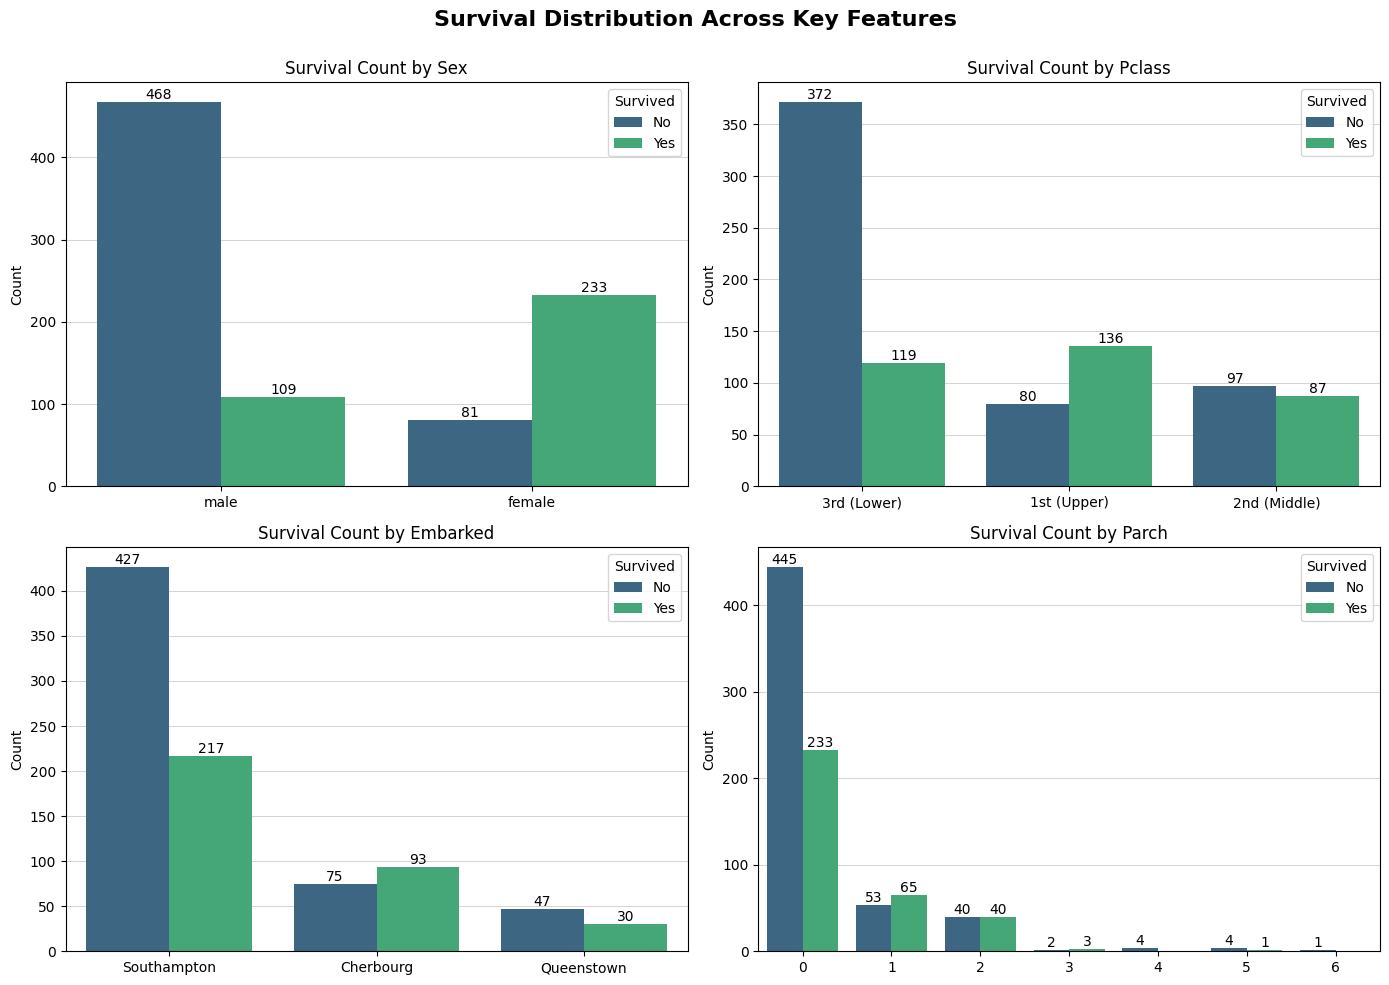

In [11]:
cols_interest = ["Sex", "Pclass", "Embarked", "Parch"]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(cols_interest):
	ax = axes[i]
	sns.countplot(data=train_eda, x=col, hue="Survived", palette="viridis", ax=ax)

	for container in ax.containers:
		ax.bar_label(container, fontsize=10)

	ax.set_title(f"Survival Count by {col}", fontsize=12)
	ax.set(xlabel="", ylabel="Count")  # noqa: E113
	ax.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax.set_axisbelow(True)
	ax.legend(title="Survived", labels=["No", "Yes"])

plt.suptitle("Survival Distribution Across Key Features", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

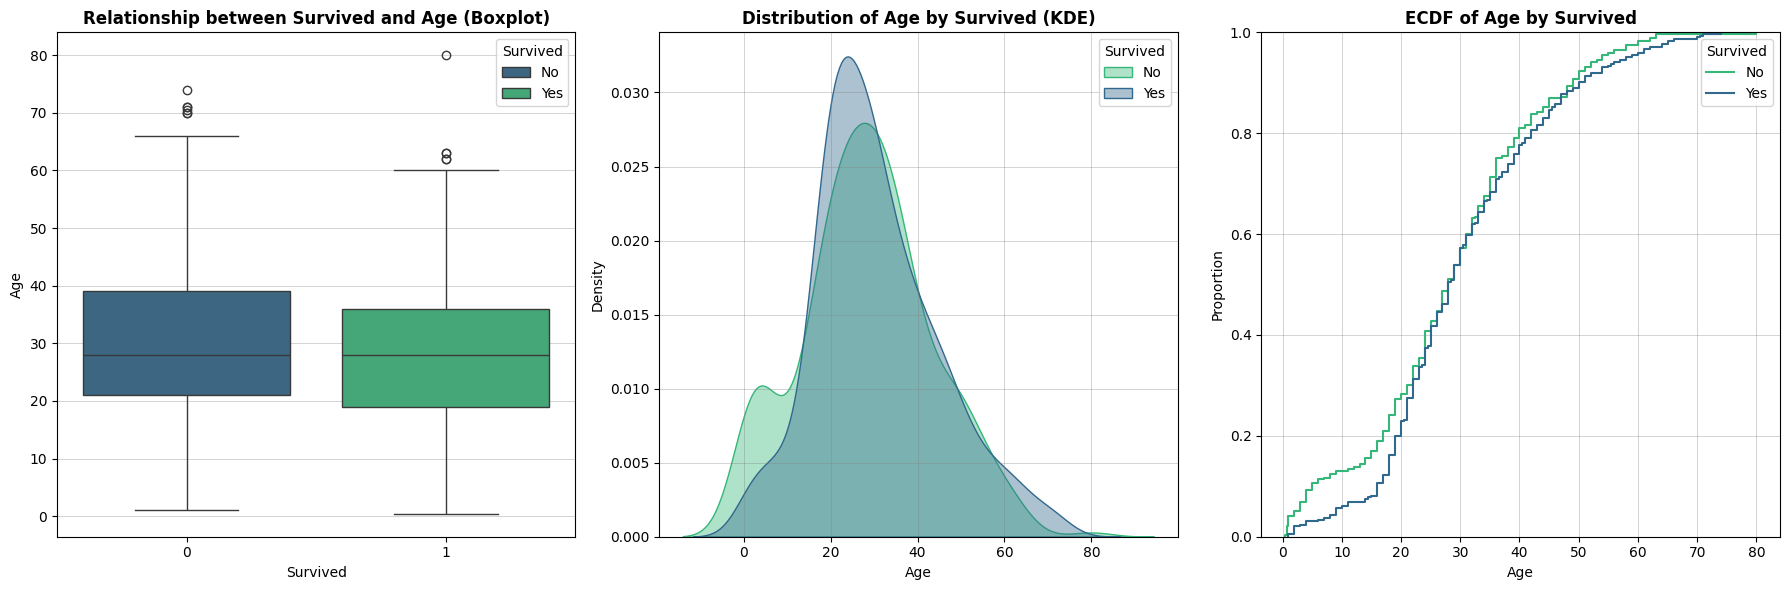

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(18, 6))


sns.boxplot(data=train_eda, x="Survived", y="Age", hue="Survived", palette="viridis", legend=True, ax=ax1)
ax1.set(xlabel="Survived", ylabel="Age")
ax1.set_title("Relationship between Survived and Age (Boxplot)", fontsize=12, fontweight="bold")
ax1.grid(True, axis="y", linewidth=0.6, alpha=0.4, color="grey")
ax1.legend(title="Survived", labels=["No", "Yes"])

sns.kdeplot(data=train_eda, x="Age", hue="Survived", palette="viridis", fill=True, common_norm=False, alpha=0.4, legend=True, ax=ax2)
ax2.set(xlabel="Age", ylabel="Density")
ax2.set_title("Distribution of Age by Survived (KDE)", fontsize=12, fontweight="bold")
ax2.grid(True, linewidth=0.6, alpha=0.4, color="grey")
ax2.legend(title="Survived", labels=["No", "Yes"])

sns.ecdfplot(data=train_eda, x="Age", hue="Survived", palette="viridis", legend=True, ax=ax3)
ax3.set(xlabel="Age", ylabel="Proportion")
ax3.set_title("ECDF of Age by Survived", fontsize=12, fontweight="bold")
ax3.grid(True, linewidth=0.6, alpha=0.4, color="grey")
ax3.legend(title="Survived", labels=["No", "Yes"])

plt.tight_layout()
plt.show()

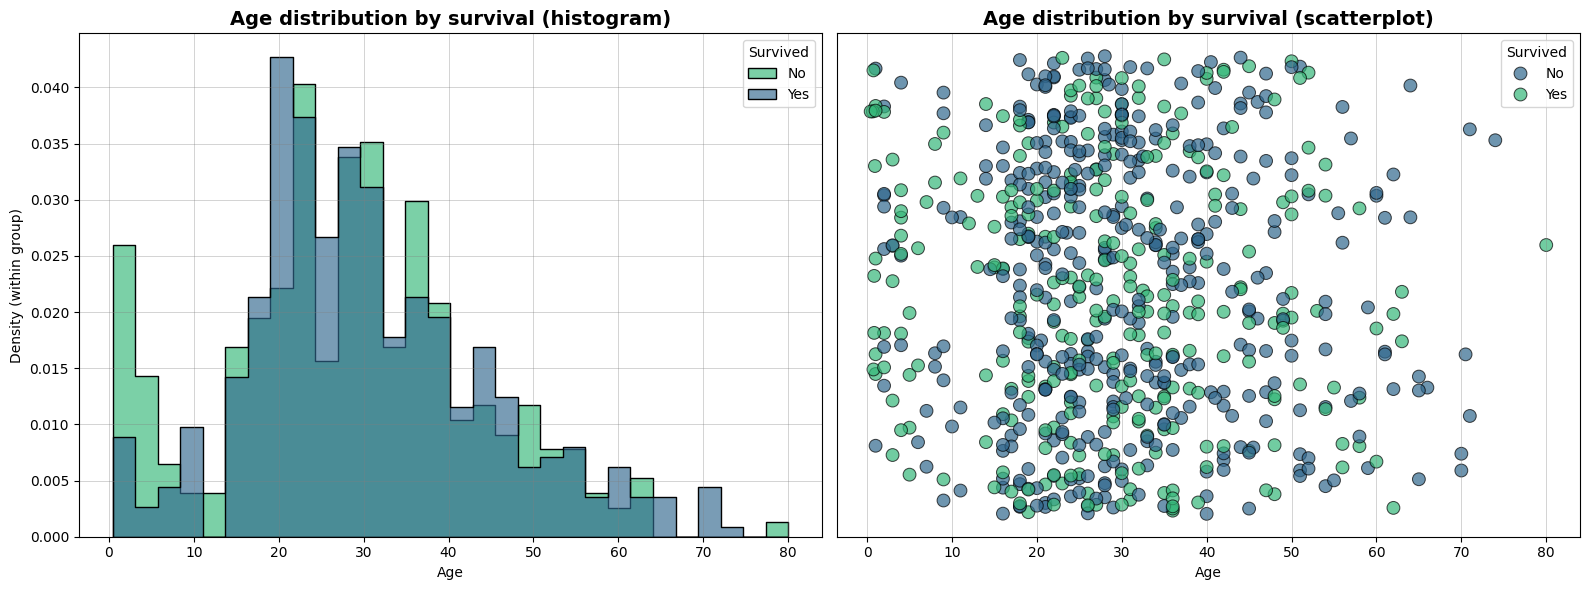

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Histogram
sns.histplot(
	data=train_eda,
	x="Age",
	hue="Survived",
	palette="viridis",
	edgecolor="black",
	bins=30,
	stat="density",
	common_norm=False,
	element="step",
	alpha=0.65,
	ax=ax1,
)
ax1.set_title("Age distribution by survival (histogram)", fontsize=14, fontweight="bold")
ax1.set(xlabel="Age", ylabel="Density (within group)")
ax1.grid(True, linewidth=0.6, alpha=0.4, color="grey")
ax1.legend(title="Survived", labels=["No", "Yes"])

# Right plot: Scatterplot
sns.scatterplot(
	data=train_eda,
	x="Age",
	y=np.random.uniform(0, 0.8, len(train_eda)),
	hue="Survived",
	palette="viridis",
	edgecolor="black",
	s=85,
	alpha=0.7,
	ax=ax2,
)
ax2.set_title("Age distribution by survival (scatterplot)", fontsize=14, fontweight="bold")
ax2.set(xlabel="Age", ylabel="")
ax2.grid(True, linewidth=0.6, alpha=0.4, color="grey")
ax2.set_yticks([])  # Remove y-axis ticks since they're arbitrary
# Get current handles and labels, then update only the labels
handles, _ = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=["No", "Yes"], title="Survived")

plt.tight_layout()
plt.show()


> The 'Age' column plays a small role in survival prediction, older people had a slightly lower chance of survival. However, the 'Age' column contains 177 missing values (about 20% of the dataset). To address this, we've got to investigate more and decide what to do about these missing values.

### Feature Engineering - Cabin Feature (Prefix and Missing Indicator)

In [14]:
train_eda.groupby("CabinCode")["Survived"].count()

,Survived
CabinCode,
A,15
B,47
C,59
D,33
E,32
F,13
G,4
T,1


### Visualising the Impact of Cabin Information (prefix of the code) on Survival

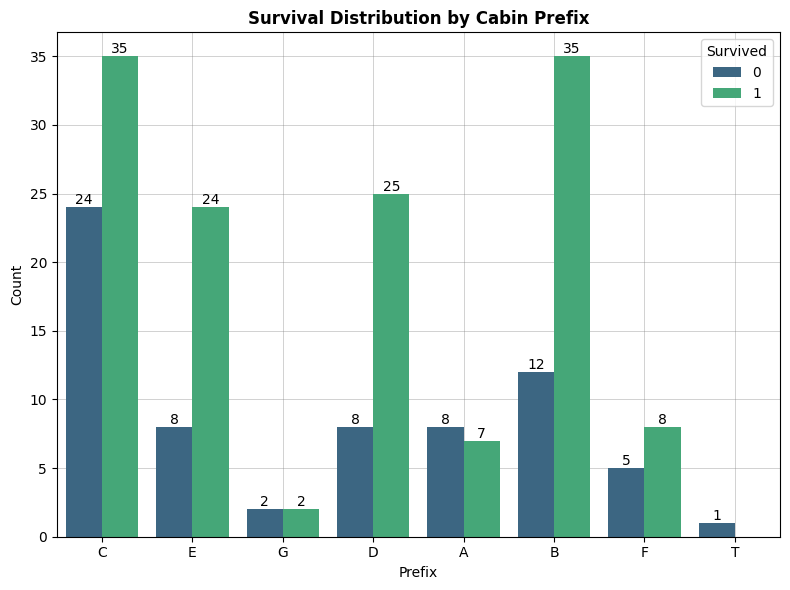

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.countplot(data=train_eda, x="CabinCode", hue="Survived", palette="viridis", ax=ax)

ax.set_title("Survival Distribution by Cabin Prefix", fontsize=12, fontweight="bold")
ax.set(xlabel="Prefix", ylabel="Count")
ax.grid(True, alpha=0.5, linewidth=0.5, color="grey")
ax.set_axisbelow(True)
for container in ax.containers:
	ax.bar_label(container, fontsize=10)

plt.tight_layout()
plt.show()

### Investigating the Impact of Missing Values in the 'Cabin' Column: Assessing Whether Missingness Is Informative or Random

In [16]:
# Subsetting the values where 'Cabin' is missing and not missing
cabin_missing = train_eda[train_eda["CabinMissing"] == "Missing"]
cabin_not_missing = train_eda[train_eda["CabinMissing"] == "Non-missing"]

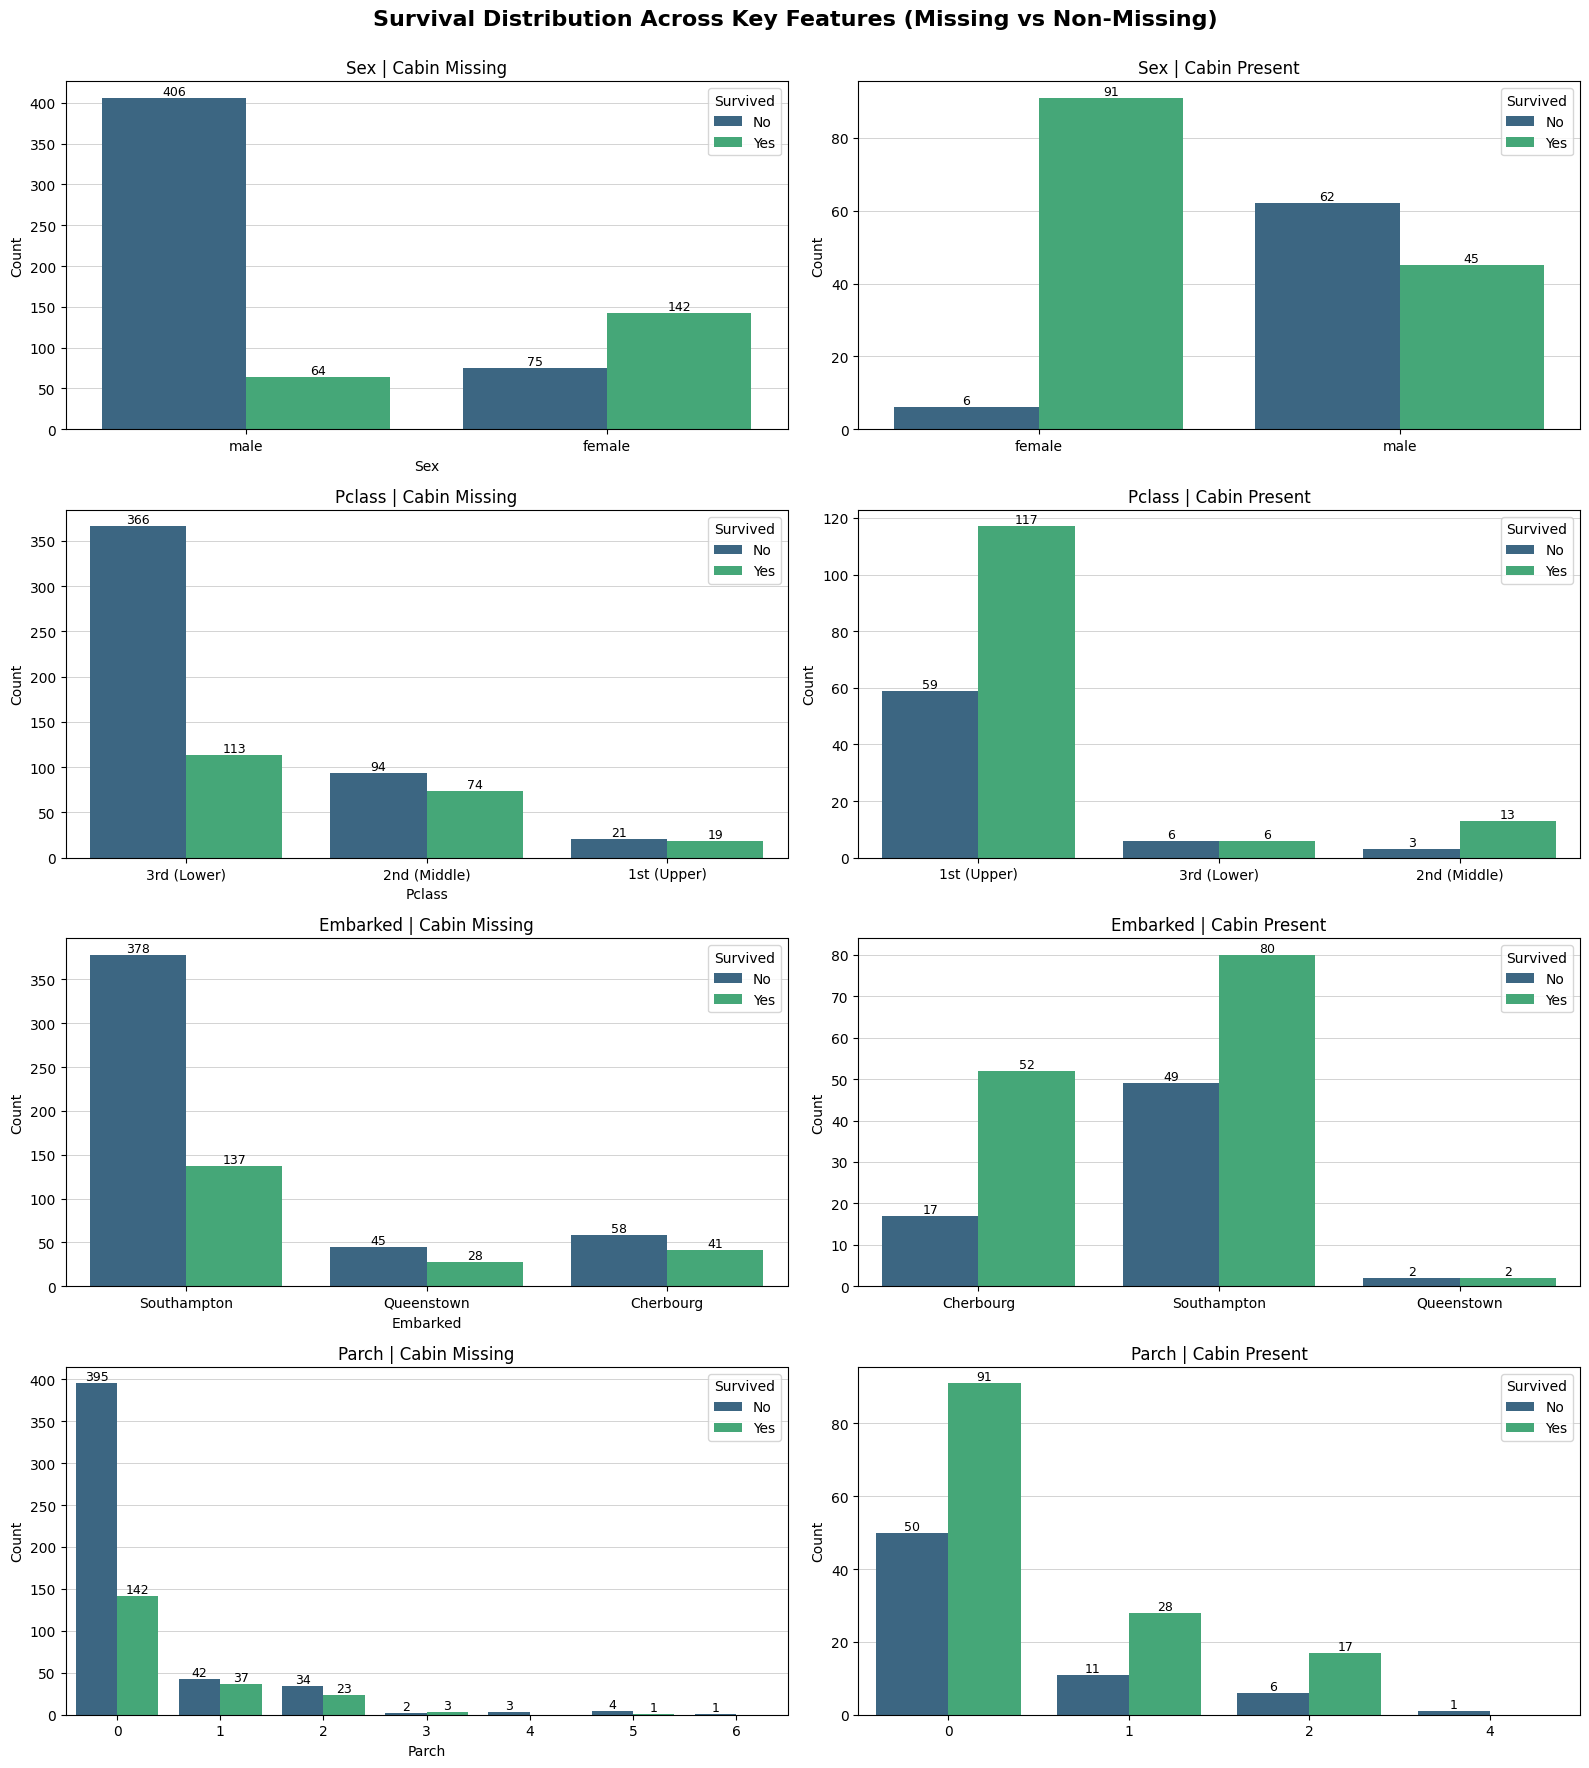

In [17]:
cols_interest = ["Sex", "Pclass", "Embarked", "Parch"]
fig, axes = plt.subplots(nrows=len(cols_interest), ncols=2, figsize=(16, 18))

for i, col in enumerate(cols_interest):
	# Left column: cabin missing
	ax_missing = axes[i, 0]
	sns.countplot(data=cabin_missing, x=col, hue="Survived", palette="viridis", ax=ax_missing)
	ax_missing.set_title(f"{col} | Cabin Missing", fontsize=12)
	ax_missing.set(xlabel=col.title(), ylabel="Count")
	ax_missing.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_missing.set_axisbelow(True)
	ax_missing.legend(title="Survived", labels=["No", "Yes"])

	for container in ax_missing.containers:
		ax_missing.bar_label(container, fontsize=9)

	# Right column: cabin present
	ax_present = axes[i, 1]
	sns.countplot(data=cabin_not_missing, x=col, hue="Survived", palette="viridis", ax=ax_present)
	ax_present.set_title(f"{col} | Cabin Present", fontsize=12)
	ax_present.set(xlabel="", ylabel="Count")
	ax_present.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_present.set_axisbelow(True)
	ax_present.legend(title="Survived", labels=["No", "Yes"])

	for container in ax_present.containers:
		ax_present.bar_label(container, fontsize=9)

plt.suptitle("Survival Distribution Across Key Features (Missing vs Non-Missing)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

> The 'Cabin' column contains a substantial number of missing values (687 out of 891). This may be due to several factors, such as passengers not being assigned a cabin or the information not being recorded correctly. Nevertheless, the presence or absence of a cabin number is likely to carry meaningful value. Clear patterns emerge, for example, passengers traveling in first class are far more likely to have a cabin number recorded than those in third class. This indicates that cabin assignment was correlated with socio-economic status, which may, in turn, have influenced survival outcomes. Therefore, rather than dropping the 'Cabin' column entirely, we can engineer additional features: a binary indicator capturing whether a cabin number was recorded, and a categorical feature derived from the cabin code prefix (the first letter of the cabin identifier).

### Investigating Missing Values from 'Age' Column

In [18]:
age_missing = train_eda[train_eda["AgeMissing"] == "Missing"]
age_not_missing = train_eda[train_eda["AgeMissing"] == "Non-missing"]

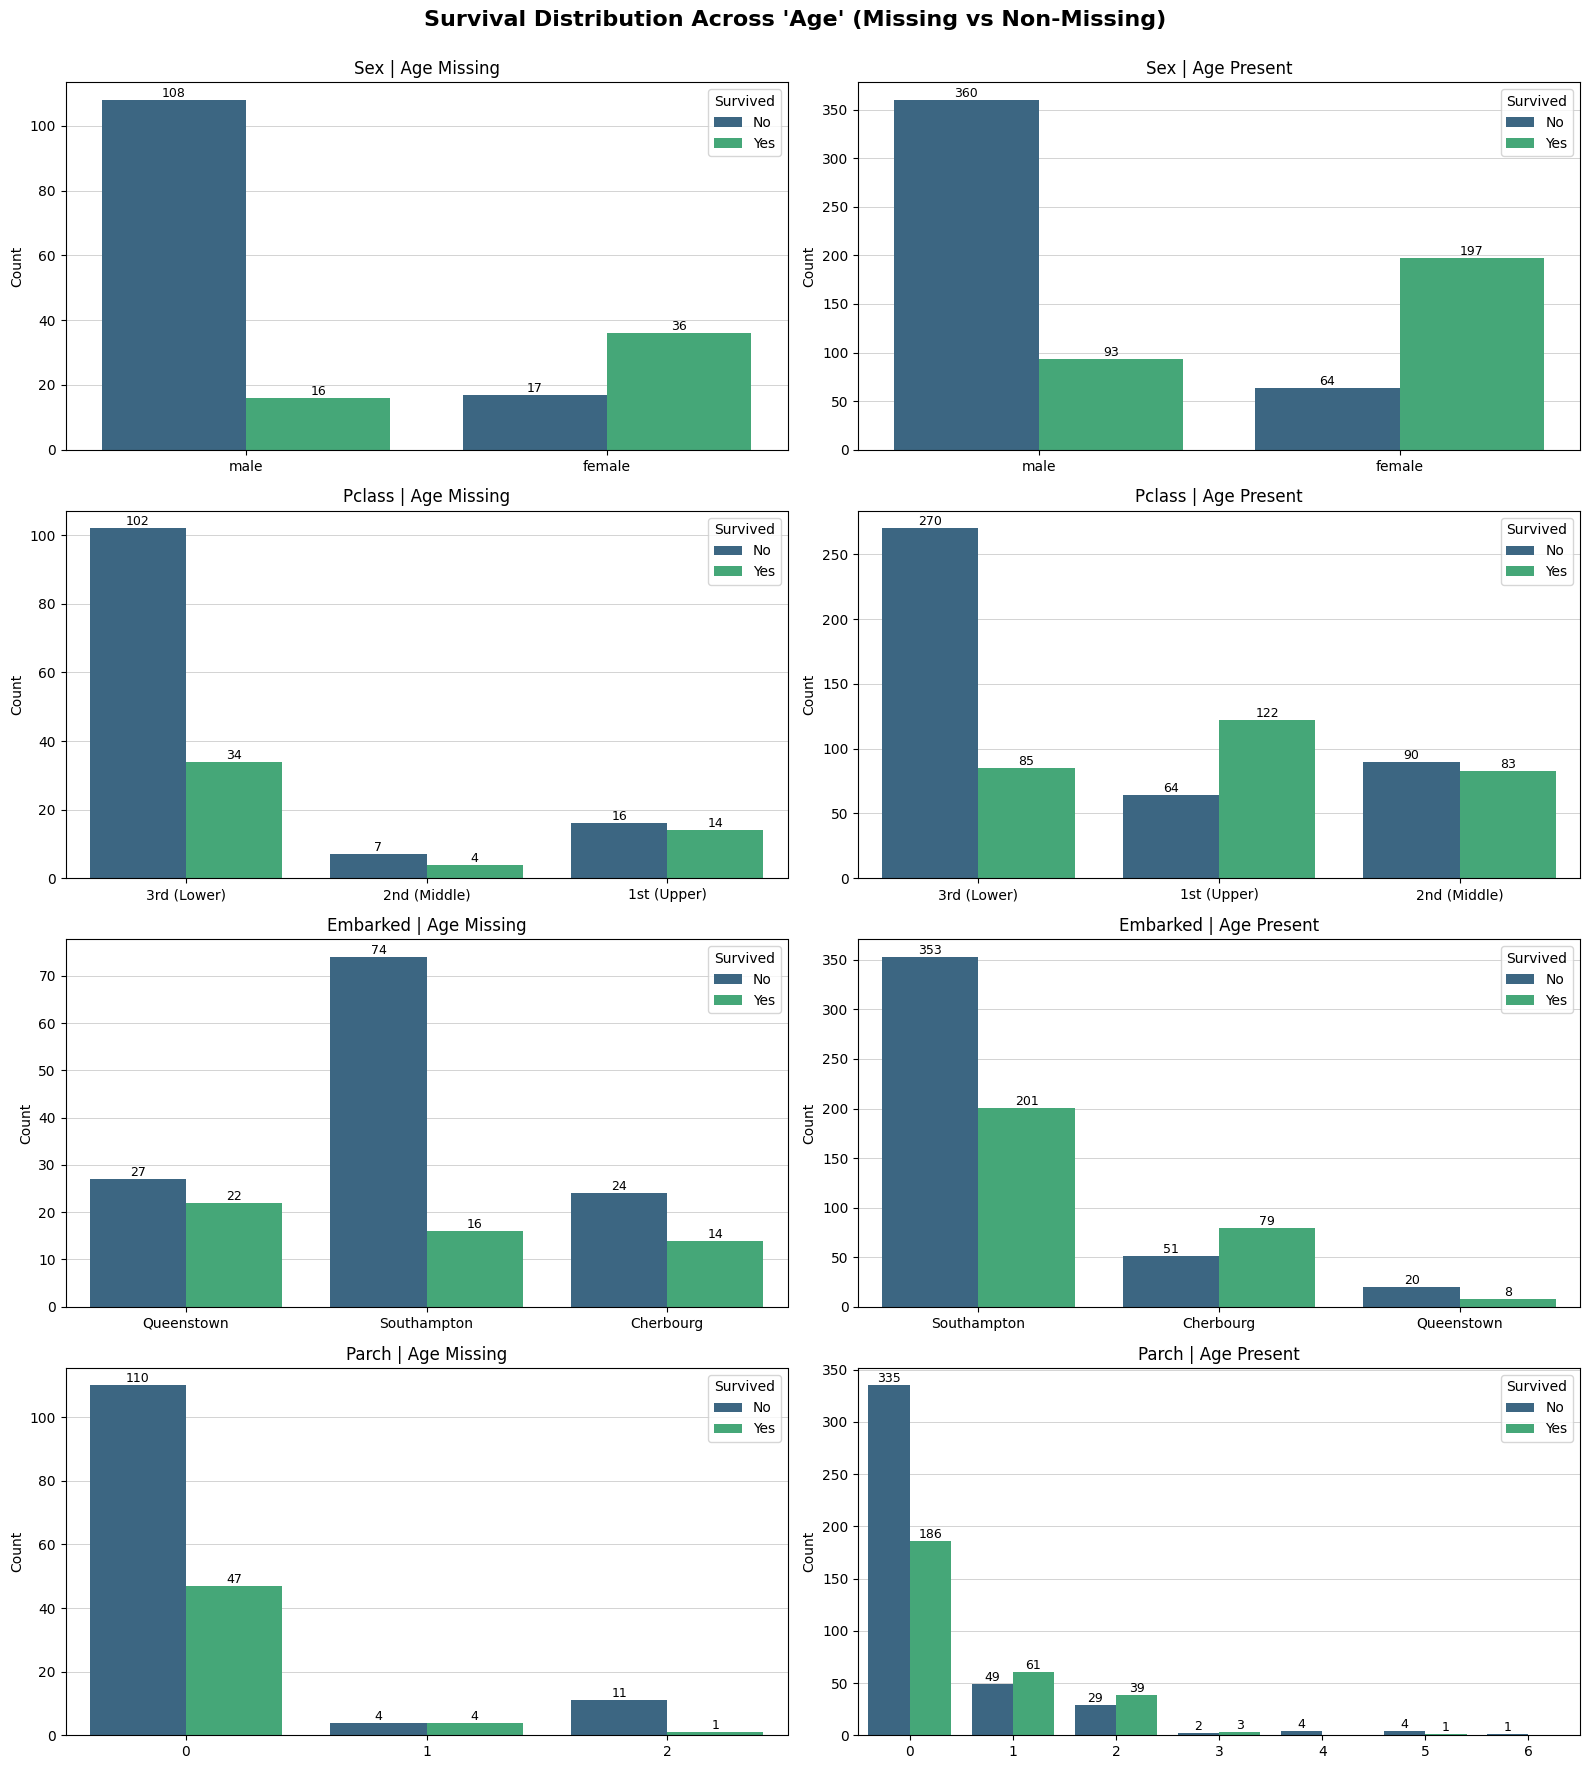

In [19]:
cols_interest = ["Sex", "Pclass", "Embarked", "Parch"]
fig, axes = plt.subplots(nrows=len(cols_interest), ncols=2, figsize=(16, 18))

for i, col in enumerate(cols_interest):
	# Left column: cabin missing
	ax_missing = axes[i, 0]
	sns.countplot(data=age_missing, x=col, hue="Survived", palette="viridis", ax=ax_missing)
	ax_missing.set_title(f"{col} | Age Missing", fontsize=12)
	ax_missing.set(xlabel="", ylabel="Count")
	ax_missing.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_missing.set_axisbelow(True)
	ax_missing.legend(title="Survived", labels=["No", "Yes"])

	for container in ax_missing.containers:
		ax_missing.bar_label(container, fontsize=9)

	# Right column: cabin present
	ax_present = axes[i, 1]
	sns.countplot(data=age_not_missing, x=col, hue="Survived", palette="viridis", ax=ax_present)
	ax_present.set_title(f"{col} | Age Present", fontsize=12)
	ax_present.set(xlabel="", ylabel="Count")
	ax_present.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_present.set_axisbelow(True)
	ax_present.legend(title="Survived", labels=["No", "Yes"])

	for container in ax_present.containers:
		ax_present.bar_label(container, fontsize=9)

plt.suptitle("Survival Distribution Across 'Age' (Missing vs Non-Missing)", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

> The 'Age' column contains a considerable number of missing values (177 out of 891). Unlike the 'Cabin' column, age does not appear to exhibit any systematic pattern of missingness when compared with other features. Therefore, the missing age values can be imputed using the median age grouped by Passenger Class and Sex. This approach represents the most reasonable solution, as it minimizes the introduction of bias or unverifiable assumptions while relying solely on information available in the dataset.


In [20]:
missing_embarked = train_eda[train_eda["Embarked"].isna()]
display(missing_embarked)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinCode,CabinMissing,AgeMissing
61,62,1,1st (Upper),"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B,Non-missing,Non-missing
829,830,1,1st (Upper),"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B,Non-missing,Non-missing


In [21]:
display(train_eda[(train_eda["Fare"] >= 80.0) & (train_eda["Fare"] <= 150.0) & (train_eda["CabinCode"] == "B")])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinCode,CabinMissing,AgeMissing
31,32,1,1st (Upper),"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,Cherbourg,B,Non-missing,Missing
61,62,1,1st (Upper),"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN,B,Non-missing,Non-missing
195,196,1,1st (Upper),"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,Cherbourg,B,Non-missing,Non-missing
257,258,1,1st (Upper),"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,B77,Southampton,B,Non-missing,Non-missing
291,292,1,1st (Upper),"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,Cherbourg,B,Non-missing,Non-missing
390,391,1,1st (Upper),"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,Southampton,B,Non-missing,Non-missing
435,436,1,1st (Upper),"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,Southampton,B,Non-missing,Non-missing
484,485,1,1st (Upper),"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,Cherbourg,B,Non-missing,Non-missing
504,505,1,1st (Upper),"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,Southampton,B,Non-missing,Non-missing
520,521,1,1st (Upper),"Perreault, Miss. Anne",female,30.0,0,0,12749,93.5000,B73,Southampton,B,Non-missing,Non-missing


In [22]:
train_eda[train_eda["Pclass"] == "1st (Upper)"].groupby("Embarked")["Fare"].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
Cherbourg,85.0,104.718529,99.093935,26.55,49.50,78.2667,110.8833,512.3292
Queenstown,2.0,90.000000,0.000000,90.00,90.00,90.0000,90.0000,90.0000
Southampton,127.0,70.364862,58.811278,0.00,29.25,52.0000,83.4750,263.0000


> The ‘Embarked’ column has only two missing values. After a thorough investigation, we found no patterns or strong clues that would allow us to infer the correct ‘Embarked’ values for these two passengers with confidence. However, because public Titanic records are readily accessible, we verified that both passengers with missing ‘Embarked’ values boarded the Titanic at Southampton (S). Therefore, we will impute these missing values with ‘Southampton’ ([source](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html)).


### Exploring the Possibility of Feature Engineering with the 'Name' Column

In [23]:
title_mapping = {
	"Mlle": "Miss",  # French for Miss
	"Ms": "Miss",
	"Mme": "Mrs",  # French for Mrs
	"Lady": "Rare_Female",
	"Countess": "Rare_Female",
	"Dona": "Rare_Female",
	"Sir": "Rare_Male",
	"Don": "Rare_Male",
	"Jonkheer": "Rare_Male",  # Dutch nobility
	"Col": "Military",
	"Major": "Military",
	"Capt": "Military",
	"Rev": "Clergy",
	"Dr": "Dr",  # Keep separate—mixed survival
}

In [24]:
# Apply title mapping to standardize title categories
train_eda["Title"] = train_eda["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
train_eda["Title"] = train_eda["Title"].replace(title_mapping)

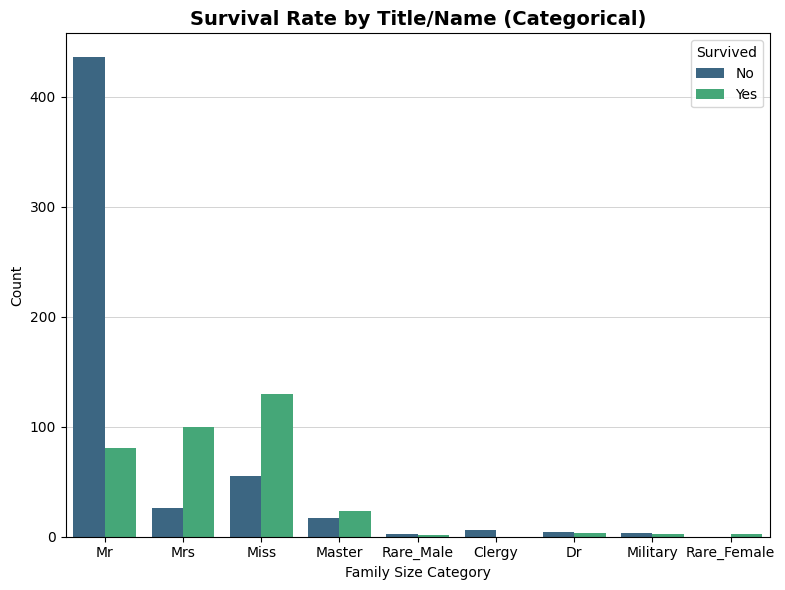

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

# Left plot: Categorical family size
sns.countplot(data=train_eda, x="Title", hue="Survived", palette="viridis", ax=ax)
ax.set_title("Survival Rate by Title/Name (Categorical)", fontsize=14, fontweight="bold")
ax.set(xlabel="Family Size Category", ylabel="Count")
ax.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
ax.set_axisbelow(True)
ax.legend(title="Survived", labels=["No", "Yes"])


plt.tight_layout()
plt.show()

> The 'Title' extracted from the 'Name' column can provide valuable insights into social status, age group, and gender, which may influence survival outcomes. By categorizing titles into broader groups (e.g., 'Mr', 'Mrs', 'Miss', 'Master', 'Other'), we can create a new feature that captures these social distinctions.

### Exploring the possibility of Feature Engineering with 'Family Size' derived from 'SibSp' and 'Parch' columns

In [26]:
# Family size
train_eda["FamilySize"] = train_eda["SibSp"] + train_eda["Parch"]
train_eda["FamilyCat"] = pd.cut(train_eda["FamilySize"], bins=[0, 1, 4, np.inf], labels=["Alone", "Small", "Large"], right=False)

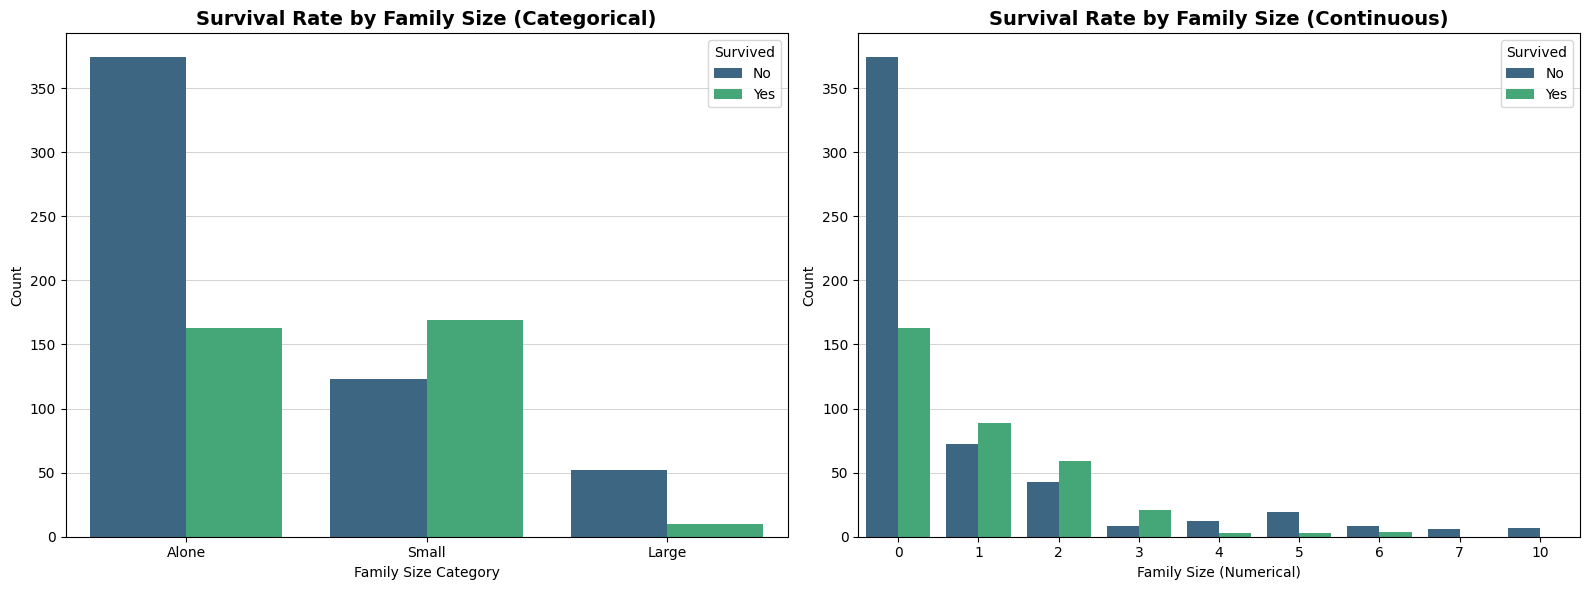

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Categorical family size
sns.countplot(data=train_eda, x="FamilyCat", hue="Survived", palette="viridis", ax=ax1)
ax1.set_title("Survival Rate by Family Size (Categorical)", fontsize=14, fontweight="bold")
ax1.set(xlabel="Family Size Category", ylabel="Count")
ax1.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
ax1.set_axisbelow(True)
ax1.legend(title="Survived", labels=["No", "Yes"])

# Right plot: Continuous family size
sns.countplot(data=train_eda, x="FamilySize", hue="Survived", palette="viridis", ax=ax2)
ax2.set_title("Survival Rate by Family Size (Continuous)", fontsize=14, fontweight="bold")
ax2.set(xlabel="Family Size (Numerical)", ylabel="Count")
ax2.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
ax2.set_axisbelow(True)
ax2.legend(title="Survived", labels=["No", "Yes"])

plt.tight_layout()
plt.show()

> The columns 'SibSp' (number of siblings/spouses aboard) and 'Parch' (number of parents/children aboard) can be combined to create a new feature called 'FamilySize'. This feature represents the total number of family members traveling together, which may influence survival chances. Additionally, we can derive together some categorical features referring to the 'bins' of FamilySize, such as 'Alone' (FamilySize = 1), 'Small' (FamilySize = 2-4), and 'Large' (FamilySize >= 5).

### Applying Transformation ad-hoc to the `train_plot` before moving on to Pipelines, Custom transformers, and Full Workflow.

In [28]:
# Fill missing Age values using the median age grouped by Passenger Class and Sex
train_eda["Age"] = train_eda.groupby(["Pclass", "Sex"])["Age"].transform(lambda x: x.fillna(x.median()))
# Note: We keep the 'Cabin' column here - the pipeline's CodeExtractor will handle extracting the code and dropping it
# Fill missing CabinCode values with 'Unknown' to handle missing cabin information
train_eda["CabinCode"] = train_eda["CabinCode"].fillna("Unknown")
# Fill missing Embarked values with 'Southampton' based on external verification
train_eda["Embarked"] = train_eda["Embarked"].fillna("Southampton")

## Split the Data into Train and Test Sets

In [29]:
train_raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [30]:
from sklearn.model_selection import train_test_split

X = train_raw.drop(labels=["PassengerId", "Survived"], axis=1)
y = train_raw["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [31]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       575 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Ticket    712 non-null    object 
 7   Fare      712 non-null    float64
 8   Cabin     160 non-null    object 
 9   Embarked  710 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 61.2+ KB


In [32]:
num_cols = ["Age", "Fare", "SibSp", "Parch"]
cat_cols = ["Pclass", "Sex", "Embarked"]

## Helper Functions

### Classification Evaluation (Plots)

In [33]:
def classification_evaluation(y: ArrayLike, X: pd.DataFrame | ArrayLike, estimator: BaseEstimator, cv: int = 5, random_state: int = 42):
	"""
	Evaluate binary classification using cross-validation.

	Parameters:
	-----------
	y : array-like
	    True labels
	X : DataFrame or array-like
	    Features
	estimator : BaseEstimator
	    Unfitted scikit-learn estimator (will be cloned for each fold)
	cv : int, default=5
	    Number of cross-validation folds
	random_state : int, default=42
	    Random state for reproducibility
	"""

	import warnings

	if not isinstance(y, (np.ndarray, pd.DataFrame, pd.Series, list)):
		raise TypeError(f"y must be array-like, got {type(y).__name__}")
	if not isinstance(X, (np.ndarray, pd.DataFrame)):
		raise TypeError(f"X must be either an Array or a DataFrame, got {type(X).__name__}")
	if not isinstance(estimator, BaseEstimator):
		raise TypeError(f"estimator must be a Scikit-Learn Estimator, got {type(estimator).__name__}")

	y_array = np.asarray(y)

	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

	# Initialize containers for CV results
	cms = []
	tprs = []
	aucs = []
	precisions_list = []
	aps = []

	# Common interpolation points
	mean_fpr = np.linspace(0, 1, 100)
	mean_recall = np.linspace(0, 1, 100)

	# Perform cross-validation
	skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

	# Track unknown categories across folds
	unknown_category_columns = set()

	# Custom warning filter
	with warnings.catch_warnings(record=True) as w:
		warnings.filterwarnings("always", category=UserWarning, module="sklearn")

		for train_idx, val_idx in skf.split(X, y_array):
			# Split data
			if isinstance(X, pd.DataFrame):
				X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
			else:
				X_train, X_val = X[train_idx], X[val_idx]

			y_train, y_val = y_array[train_idx], y_array[val_idx]

			# Clone and fit estimator
			fold_estimator = clone(estimator)
			fold_estimator.fit(X_train, y_train)

			# Get predictions
			y_pred = fold_estimator.predict(X_val)
			y_proba = fold_estimator.predict_proba(X_val)[:, 1]

			# Confusion matrix (normalised)
			cm = confusion_matrix(y_true=y_val, y_pred=y_pred, normalize="true")
			cms.append(cm)

			# ROC curve
			fpr, tpr, _ = roc_curve(y_true=y_val, y_score=y_proba)
			roc_auc = roc_auc_score(y_true=y_val, y_score=y_proba)

			interp_tpr = np.interp(mean_fpr, fpr, tpr)
			interp_tpr[0] = 0.0
			tprs.append(interp_tpr)
			aucs.append(roc_auc)

			# Precision-Recall curve
			precision, recall, _ = precision_recall_curve(y_true=y_val, y_score=y_proba)
			avg_precision = average_precision_score(y_true=y_val, y_score=y_proba)

			# Interpolate precision
			interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
			precisions_list.append(interp_precision)
			aps.append(avg_precision)

		# Process warnings
		for warning in w:
			if "unknown categories" in str(warning.message).lower():
				import re

				match = re.search(r"columns \[([^\]]+)\]", str(warning.message))
				if match:
					cols = match.group(1).split(",")
					unknown_category_columns.update([int(c.strip()) for c in cols])

	# Display custom warning if unknown categories were found
	if unknown_category_columns:
		cols_list = sorted(list(unknown_category_columns))
		print(f"Unknown categories found in columns {cols_list} will be encoded as zeros.")

	# Mean Confusion Matrix
	mean_cm = np.mean(cms, axis=0)
	std_cm = np.std(cms, axis=0)

	# Create annotation labels with mean ± std
	annot_labels = np.array([[f"{mean_cm[i, j]:.1%}\n(±{std_cm[i, j]:.1%})" for j in range(2)] for i in range(2)])

	cm_df = pd.DataFrame(
		data=mean_cm,
		index=["Actual Negative", "Actual Positive"],
		columns=["Pred Negative", "Pred Positive"],
	)

	sns.heatmap(
		data=cm_df,
		annot=annot_labels,
		fmt="",
		cmap="Blues",
		cbar_kws={"label": "Proportion"},
		ax=axes[0],
		vmin=0,
		vmax=1,
	)
	axes[0].set_title(f"Mean Confusion Matrix\n({cv}-Fold CV, Row-Normalised)", fontsize=11, pad=9)
	axes[0].set_xlabel("Predicted Label")
	axes[0].set_ylabel("True Label")

	# Mean ROC Curve
	mean_tpr = np.mean(tprs, axis=0)
	mean_tpr[-1] = 1.0
	std_tpr = np.std(tprs, axis=0)
	mean_auc = np.mean(aucs)
	std_auc = np.std(aucs)

	axes[1].plot(mean_fpr, mean_tpr, color="darkorange", linewidth=2.5, label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})")

	axes[1].fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0), np.minimum(mean_tpr + std_tpr, 1), color="darkorange", alpha=0.2, label="± 1 std. dev.")

	axes[1].plot([0, 1], [0, 1], color="navy", linestyle="--", alpha=0.5, label="Chance (AUC = 0.5)")
	axes[1].set_title(f"Mean ROC Curve ({cv}-Fold CV)", fontsize=11, pad=9)
	axes[1].set_xlabel("False Positive Rate (1 - Specificity)")
	axes[1].set_ylabel("True Positive Rate (Sensitivity)")
	axes[1].set_xlim([-0.02, 1.02])
	axes[1].set_ylim([-0.02, 1.02])
	axes[1].legend(loc="lower right", frameon=True, fancybox=True, shadow=True)
	axes[1].grid(True, alpha=0.4, linewidth=0.4, color="grey")

	# Mean Precision-Recall Curve
	mean_precision = np.mean(precisions_list, axis=0)
	std_precision = np.std(precisions_list, axis=0)
	mean_ap = np.mean(aps)
	std_ap = np.std(aps)

	axes[2].plot(
		mean_recall,
		mean_precision,
		color="forestgreen",
		linewidth=2.5,
		label=f"Mean PR (AP = {mean_ap:.3f} ± {std_ap:.3f})",
	)

	axes[2].fill_between(
		mean_recall, np.maximum(mean_precision - std_precision, 0), np.minimum(mean_precision + std_precision, 1), color="forestgreen", alpha=0.2, label="± 1 std. dev."
	)

	# Baseline prevalence
	baseline = np.mean(y_array)
	axes[2].axhline(
		y=baseline,
		color="dimgrey",
		linestyle="--",
		linewidth=2,
		alpha=0.7,
		label=f"Baseline (Prevalence = {baseline:.3f})",
	)

	axes[2].set_title(f"Mean Precision-Recall Curve ({cv}-Fold CV)", fontsize=11, pad=9)
	axes[2].set_xlabel("Recall (Sensitivity)")
	axes[2].set_ylabel("Precision (PPV)")
	axes[2].set_xlim([-0.02, 1.02])
	axes[2].set_ylim([0.0, 1.05])
	axes[2].legend(loc="best", frameon=True, fancybox=True, shadow=True)
	axes[2].grid(True, alpha=0.4, linewidth=0.4, color="grey")

	# Extract model name
	if hasattr(estimator, "named_steps") and "model" in estimator.named_steps:
		model_name = estimator.named_steps["model"].__class__.__name__
	elif hasattr(estimator, "steps"):
		model_name = estimator.steps[-1][1].__class__.__name__
	else:
		model_name = estimator.__class__.__name__

	plt.suptitle(f"Binary Classification: {model_name} ({cv}-Fold Cross-Validation)", fontsize=14, fontweight="bold")
	plt.tight_layout()
	plt.show()

### Evaluate Candidates (Computing Metrics)

In [34]:
SortMetric = Literal["accuracy", "f1", "roc_auc"]


def evaluate_candidates(
	candidates: dict[str, BaseEstimator],
	X,
	y,
	*,
	n_splits: int = 5,
	sort_by: SortMetric = "roc_auc",
	n_jobs: int = -1,
	verbose: bool = True,
	return_train_score: bool = False,
	error_score: float | int | str = np.nan,
) -> pd.DataFrame:
	"""
	Cross-validate a set of candidate estimators/pipelines on the same splits and
	return a sorted summary table.

	Notes:
	- Uses StratifiedKFold (appropriate for classification like Titanic).
	- Computes mean and std for each metric across folds.
	"""
	cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
	scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

	results_list: list[dict[str, object]] = []

	for name, model in candidates.items():
		if verbose:
			print(f"Evaluating {name}...")

		cv_results = cross_validate(
			model,
			X,
			y,
			cv=cv,
			scoring=scoring,
			n_jobs=n_jobs,
			return_train_score=return_train_score,
			error_score=error_score,
		)

		row: dict[str, object] = {"Model": name}

		for key, scores in cv_results.items():
			if key.endswith("_time"):
				continue

			scores_array = np.asarray(scores, dtype=float)
			row[f"{key} (mean)"] = float(np.nanmean(scores_array))
			row[f"{key} (std)"] = float(np.nanstd(scores_array, ddof=0))

		results_list.append(row)

	df = pd.DataFrame(results_list)

	sort_col = f"test_{sort_by} (mean)"
	if sort_col not in df.columns:
		# Fallback if something went wrong or metric missing
		available = [c for c in df.columns if c.startswith("test_") and c.endswith("(mean)")]
		sort_col = available[0] if available else df.columns[0]

	return df.sort_values(sort_col, ascending=False).reset_index(drop=True)

## Pipeline Factory & Custom Transformers

### Custom Transformers for Data Preparation and Feature Engineering

In [35]:
from typing import Sequence

from sklearn.utils.validation import check_is_fitted


class ValueDecoder(BaseEstimator, TransformerMixin):
	def __init__(
		self,
		*,
		pclass: dict | None = None,
		embarked: dict | None = None,
		titles: dict | None = None,
	) -> None:
		self.pclass = pclass or {}
		self.embarked = embarked or {}
		self.titles = titles or {}

	def fit(self, X: pd.DataFrame, y=None):  # noqa: N803
		if not isinstance(X, pd.DataFrame):
			raise TypeError("ValueDecoder expects a pandas DataFrame.")
		self.is_fitted_ = True
		return self

	def transform(self, X: pd.DataFrame) -> pd.DataFrame:  # noqa: N803
		check_is_fitted(self, "is_fitted_")

		if not isinstance(X, pd.DataFrame):
			raise TypeError("ValueDecoder expects a pandas DataFrame.")

		X = X.copy()

		if "Pclass" in X.columns and self.pclass:
			X["Pclass"] = X["Pclass"].replace(self.pclass)

		if "Embarked" in X.columns and self.embarked:
			X["Embarked"] = X["Embarked"].replace(self.embarked)

		if "Name" in X.columns and self.titles:
			X["Title"] = X["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
			X["Title"] = X["Title"].replace(self.titles)

		return X


class CodeExtractor(BaseEstimator, TransformerMixin):
	def __init__(
		self,
		cabin_col: str = "Cabin",
		*,
		output_col: str = "CabinCode",
		missing_value: str = "Unknown",
		drop_original: bool = True,
	) -> None:
		self.cabin_col = cabin_col
		self.output_col = output_col
		self.missing_value = missing_value
		self.drop_original = drop_original

	def fit(self, X: pd.DataFrame, y=None):  # noqa: N803
		if not isinstance(X, pd.DataFrame):
			raise TypeError("CodeExtractor expects a pandas DataFrame.")
		if self.cabin_col not in X.columns:
			raise ValueError(f"Missing column: {self.cabin_col}")
		self.is_fitted_ = True
		return self

	def transform(self, X: pd.DataFrame) -> pd.DataFrame:  # noqa: N803
		check_is_fitted(self, "is_fitted_")
		X = X.copy()

		cabin_series = X[self.cabin_col].astype("string")
		code = cabin_series.str.strip().str[0].fillna(self.missing_value)
		X[self.output_col] = code

		if self.drop_original:
			X = X.drop(columns=[self.cabin_col])

		return X


class MissingIndicatorFeatures(BaseEstimator, TransformerMixin):
	def __init__(
		self,
		missing_cols: list[str],
		*,
		prefix: str = "Missing_",
		as_int: bool = True,
	) -> None:
		self.missing_cols = missing_cols
		self.prefix = prefix
		self.as_int = as_int

	def fit(self, X: pd.DataFrame, y=None):  # noqa: N803
		if not isinstance(X, pd.DataFrame):
			raise TypeError("MissingIndicatorFeatures expects a pandas DataFrame.")
		missing = [c for c in self.missing_cols if c not in X.columns]
		if missing:
			raise ValueError(f"Missing columns: {missing}")
		self.is_fitted_ = True
		return self

	def transform(self, X: pd.DataFrame) -> pd.DataFrame:
		check_is_fitted(self, "is_fitted_")
		X = X.copy()

		for col in self.missing_cols:
			indicator = X[col].isna()
			X[f"{self.prefix}{col}"] = indicator.astype("int8") if self.as_int else indicator

		return X


class FamilyFeatures(BaseEstimator, TransformerMixin):
	"""
	- FamilySize = SibSp + Parch + 1
	- Alone = (FamilySize == 1)
	- FamilyCat: Alone / Small (2-4) / Large (5+)
	- Optional cap on FamilySize
	"""

	def __init__(
		self,
		sibsp_col: str = "SibSp",
		parch_col: str = "Parch",
		*,
		size_col: str = "FamilySize",
		alone_col: str = "Alone",
		cat_col: str = "FamilyCat",
		cap_at: int | None = 6,
		small_max: int = 4,
	) -> None:
		self.sibsp_col = sibsp_col
		self.parch_col = parch_col
		self.size_col = size_col
		self.alone_col = alone_col
		self.cat_col = cat_col
		self.cap_at = cap_at
		self.small_max = small_max

	def fit(self, X: pd.DataFrame, y=None):  # noqa: N803
		if not isinstance(X, pd.DataFrame):
			raise TypeError("FamilyFeatures expects a pandas DataFrame.")
		for col in [self.sibsp_col, self.parch_col]:
			if col not in X.columns:
				raise ValueError(f"Missing column: {col}")
		self.is_fitted_ = True
		return self

	def transform(self, X: pd.DataFrame) -> pd.DataFrame:  # noqa: N803
		check_is_fitted(self, "is_fitted_")
		X = X.copy()

		sibsp = X[self.sibsp_col].fillna(0).astype(float)
		parch = X[self.parch_col].fillna(0).astype(float)

		family_size = sibsp + parch + 1

		if self.cap_at is not None:
			family_size = family_size.clip(upper=self.cap_at)

		X[self.size_col] = family_size.astype("int16")
		X[self.alone_col] = (X[self.size_col] == 1).astype("int8")

		conditions = [
			X[self.size_col] == 1,
			(X[self.size_col] >= 2) & (X[self.size_col] <= self.small_max),
			X[self.size_col] > self.small_max,
		]
		choices = ["Alone", "Small", "Large"]
		X[self.cat_col] = np.select(conditions, choices, default="Unknown")

		return X


class GroupMedianImputer(BaseEstimator, TransformerMixin):
	"""
	Impute missing values in a numeric column using the median within groups
	defined by `group_cols`. Unseen groups fall back to the global median.
	"""

	def __init__(
		self,
		group_cols: Sequence[str],
		target_col: str,
		*,
		output_col: str | None = None,
	) -> None:
		self.group_cols = group_cols
		self.target_col = target_col
		self.output_col = output_col

	def fit(self, X: pd.DataFrame, y=None):  # noqa: N803
		if not isinstance(X, pd.DataFrame):
			raise TypeError("GroupMedianImputer expects a pandas DataFrame.")

		group_cols_list = list(self.group_cols)
		missing = [c for c in [*group_cols_list, self.target_col] if c not in X.columns]
		if missing:
			raise ValueError(f"Missing required columns: {missing}")

		if not pd.api.types.is_numeric_dtype(X[self.target_col]):
			raise TypeError(f"'{self.target_col}' must be numeric.")

		self.output_col_ = self.output_col or self.target_col

		group_medians = X.groupby(group_cols_list, dropna=False)[self.target_col].median()
		global_median = float(pd.Series(X[self.target_col]).median())

		if np.isnan(global_median):
			raise ValueError(f"Global median for '{self.target_col}' is NaN; column may be entirely missing.")

		self.group_medians_ = group_medians
		self.global_median_ = global_median
		self.is_fitted_ = True
		return self

	def transform(self, X: pd.DataFrame) -> pd.DataFrame:  # noqa: N803
		check_is_fitted(self, ["is_fitted_", "group_medians_", "global_median_"])

		if not isinstance(X, pd.DataFrame):
			raise TypeError("GroupMedianImputer expects a pandas DataFrame.")

		X = X.copy()
		missing_mask = X[self.target_col].isna()

		if not missing_mask.any():
			if self.output_col_ != self.target_col:
				X[self.output_col_] = X[self.target_col]
			return X

		if self.output_col_ != self.target_col:
			X[self.output_col_] = X[self.target_col]

		group_cols_list = list(self.group_cols)
		keys = pd.MultiIndex.from_frame(X.loc[missing_mask, group_cols_list])
		fill_values = self.group_medians_.reindex(keys).to_numpy(dtype=float)
		fill_values = np.where(np.isnan(fill_values), self.global_median_, fill_values)

		X.loc[missing_mask, self.output_col_] = fill_values
		return X


In [36]:
pclass = {1: "First", 2: "Second", 3: "Third"}
embarked = {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"}
title_mapping = {
	"Mlle": "Miss",  # French for Miss
	"Ms": "Miss",
	"Mme": "Mrs",  # French for Mrs
	"Lady": "Rare_Female",
	"Countess": "Rare_Female",
	"Dona": "Rare_Female",
	"Sir": "Rare_Male",
	"Don": "Rare_Male",
	"Jonkheer": "Rare_Male",  # Dutch nobility
	"Col": "Military",
	"Major": "Military",
	"Capt": "Military",
	"Rev": "Clergy",
	"Dr": "Dr",  # Keep separate—mixed survival
}


def make_feature_engineering() -> Pipeline:
	return Pipeline(
		steps=[
			("decode", ValueDecoder(pclass=pclass, embarked=embarked, titles=title_mapping)),
			("family", FamilyFeatures(sibsp_col="SibSp", parch_col="Parch")),
			("missing", MissingIndicatorFeatures(missing_cols=["Age", "Cabin", "Embarked"])),
			("age_impute", GroupMedianImputer(group_cols=["Pclass", "Sex"], target_col="Age")),
			("cabin_code", CodeExtractor(cabin_col="Cabin", output_col="CabinCode", missing_value="Unknown")),
		]
	)


def make_preprocessor(
	cat_cols: list[str],
	num_cols: list[str],
	*,
	scale_numeric: bool,
) -> ColumnTransformer:
	cat_pipe = Pipeline(steps=[("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"))])
	if scale_numeric:
		num_pipe = Pipeline(steps=[("scaler", StandardScaler(with_mean=False))])
	else:
		num_pipe = "passthrough"

	return ColumnTransformer(
		transformers=[
			("categorical", cat_pipe, cat_cols),
			("numerical", num_pipe, num_cols),
		],
		remainder="drop",
	)


def _dedupe_preserve_order(items: list[str]) -> list[str]:
	seen: set[str] = set()
	out: list[str] = []
	for item in items:
		if item not in seen:
			seen.add(item)
			out.append(item)
	return out


def make_model_pipeline(model, *, cat_cols: list[str], num_cols: list[str], scale_numeric: bool) -> Pipeline:
	cat_extra = ["CabinCode", "FamilyCat"]
	num_extra = ["FamilySize", "Missing_Age", "Missing_Cabin", "Missing_Embarked"]

	cat_cols_fe = _dedupe_preserve_order(cat_cols + cat_extra)
	num_cols_fe = _dedupe_preserve_order(num_cols + num_extra)

	return Pipeline(
		steps=[
			("feat_eng", make_feature_engineering()),
			("preprocess", make_preprocessor(cat_cols_fe, num_cols_fe, scale_numeric=scale_numeric)),
			("model", model),
		]
	)


### Baseline Performance - LogReg

In [37]:
from sklearn.linear_model import LogisticRegression

logreg_model = LogisticRegression(
	max_iter=5000,
	random_state=42,
)

logreg_pipe = make_model_pipeline(
	logreg_model,
	cat_cols=cat_cols,
	num_cols=num_cols,
	scale_numeric=True,
)

logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('feat_eng',
                 Pipeline(steps=[('decode',
                                  ValueDecoder(embarked={'C': 'Cherbourg',
                                                         'Q': 'Queenstown',
                                                         'S': 'Southampton'},
                                               pclass={1: 'First', 2: 'Second',
                                                       3: 'Third'},
                                               titles={'Capt': 'Military',
                                                       'Col': 'Military',
                                                       'Countess': 'Rare_Female',
                                                       'Don': 'Rare_Male',
                                                       'Dona': 'Rare_Female',
                                                       'Dr': 'Dr',
                                                       'Jonkheer': 'Rare_Male',
                                                       'Lady': 'Rare_Female',
                                                       'Major': 'Military',
                                                       '...
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'CabinCode', 'FamilyCat']),
                                                 ('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['Age', 'Fare', 'SibSp',
                                                   'Parch', 'FamilySize',
                                                   'Missing_Age',
                                                   'Missing_Cabin',
                                                   'Missing_Embarked'])])),
                ('model', LogisticRegression(max_iter=5000, random_state=42))])

Evaluating base_lr...


,Model,test_accuracy (mean),test_accuracy (std),test_f1 (mean),test_f1 (std),test_roc_auc (mean),test_roc_auc (std)
0,base_lr,0.807623,0.01589,0.741134,0.018946,0.863527,0.019193


Unknown categories found in columns [3] will be encoded as zeros.


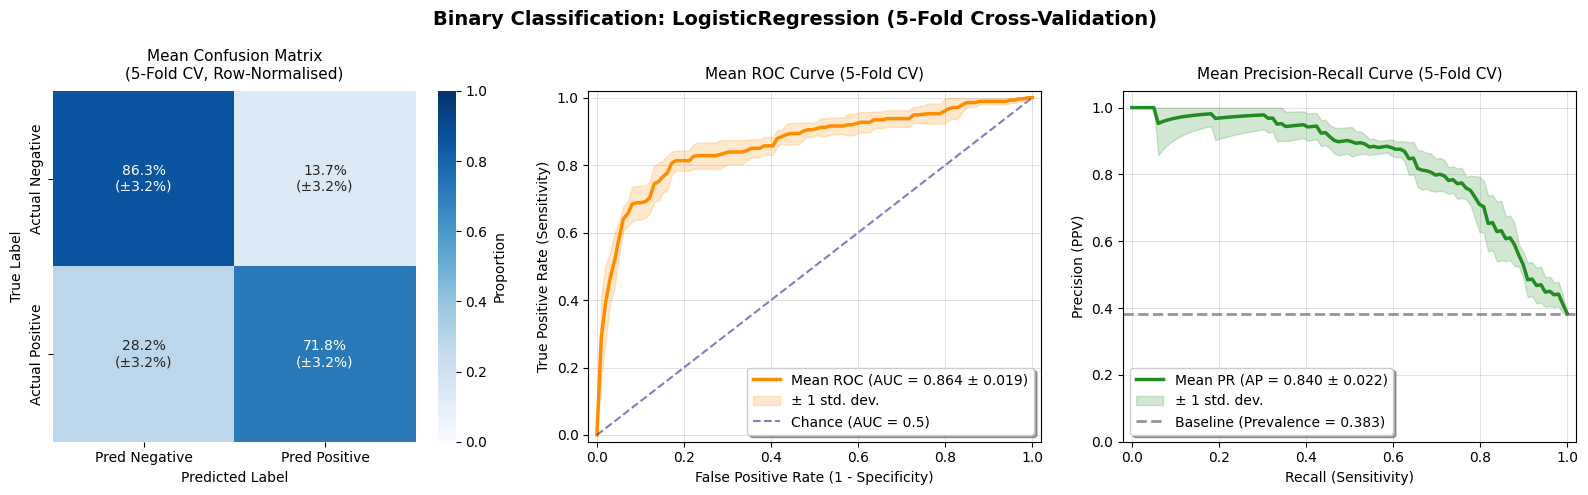

In [38]:
base_logreg = evaluate_candidates(
	candidates={"base_lr": logreg_pipe},
	X=X_train,
	y=y_train,
	n_splits=5,
	n_jobs=-1,
)

display(base_logreg)
classification_evaluation(X=X_train, y=y_train, estimator=logreg_pipe)

## Evaluating Candidates - Computing Metrics

### 1) Ensembles: `AdaBoostClassifier`, `HistGradientBoostingClassifier`, `RandomForestClassifier`

In [39]:
from sklearn.ensemble import AdaBoostClassifier, HistGradientBoostingClassifier, RandomForestClassifier

Evaluating HGB...
Evaluating RF...
Evaluating ADA...


,Model,test_accuracy (mean),test_accuracy (std),test_f1 (mean),test_f1 (std),test_roc_auc (mean),test_roc_auc (std)
0,HGB,0.806205,0.025521,0.739917,0.030394,0.880576,0.019076
1,ADA,0.818852,0.023457,0.765525,0.025734,0.874882,0.025397
2,RF,0.797735,0.012343,0.732025,0.015588,0.867601,0.013537


Unknown categories found in columns [3] will be encoded as zeros.


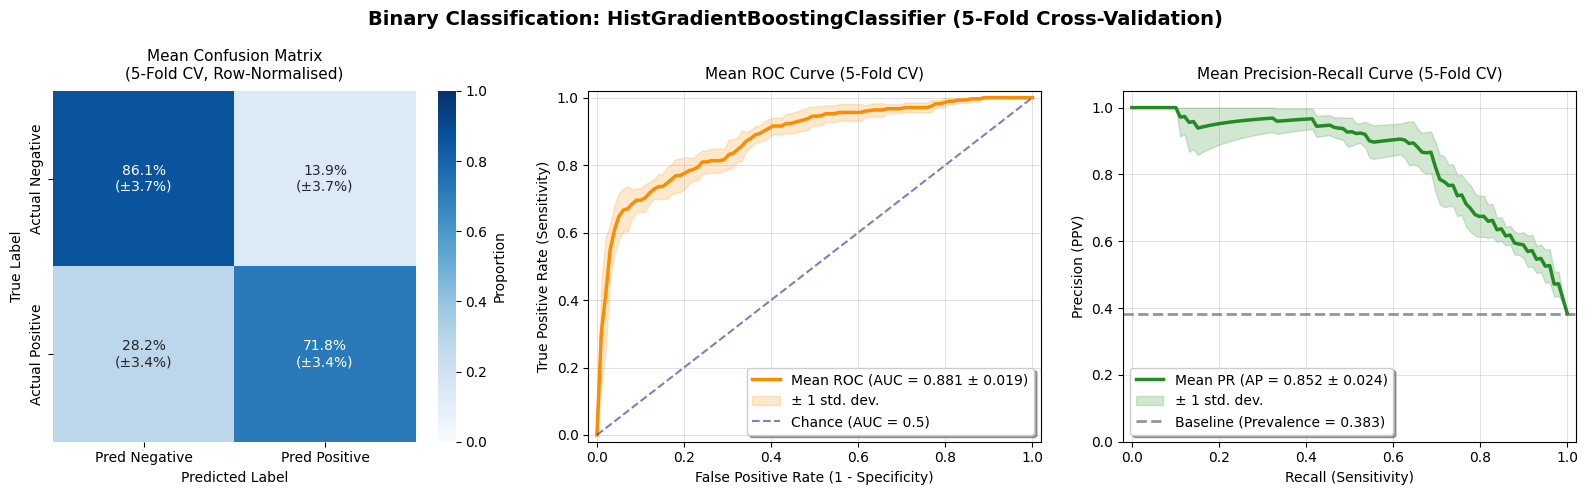

Unknown categories found in columns [3] will be encoded as zeros.


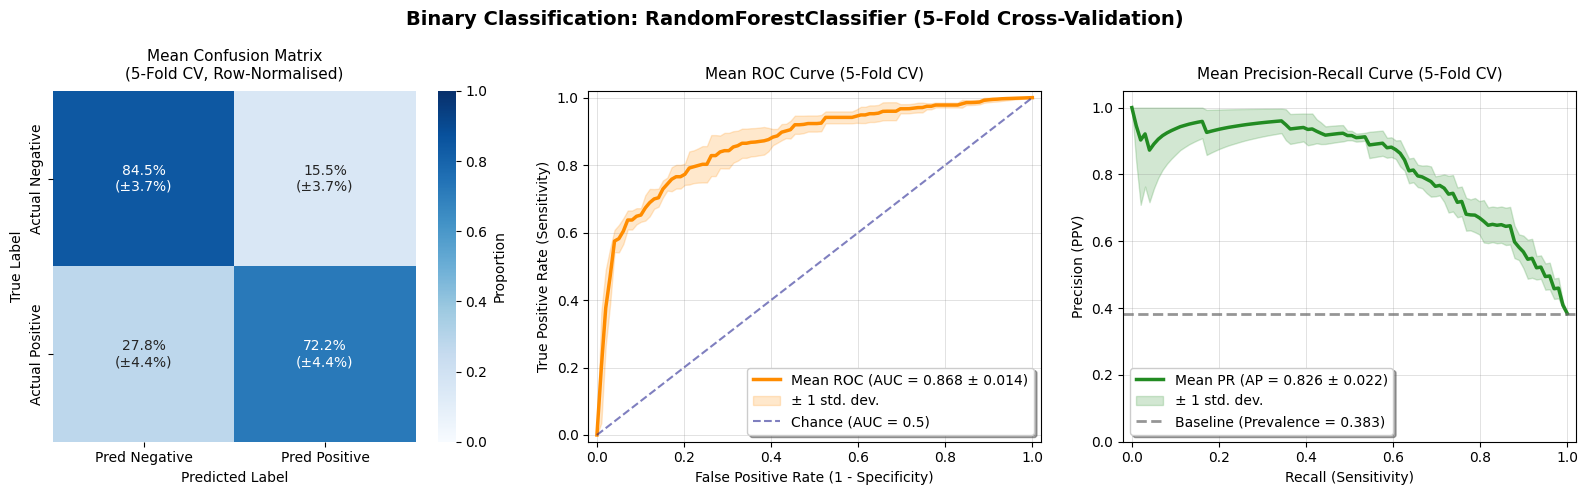

Unknown categories found in columns [3] will be encoded as zeros.


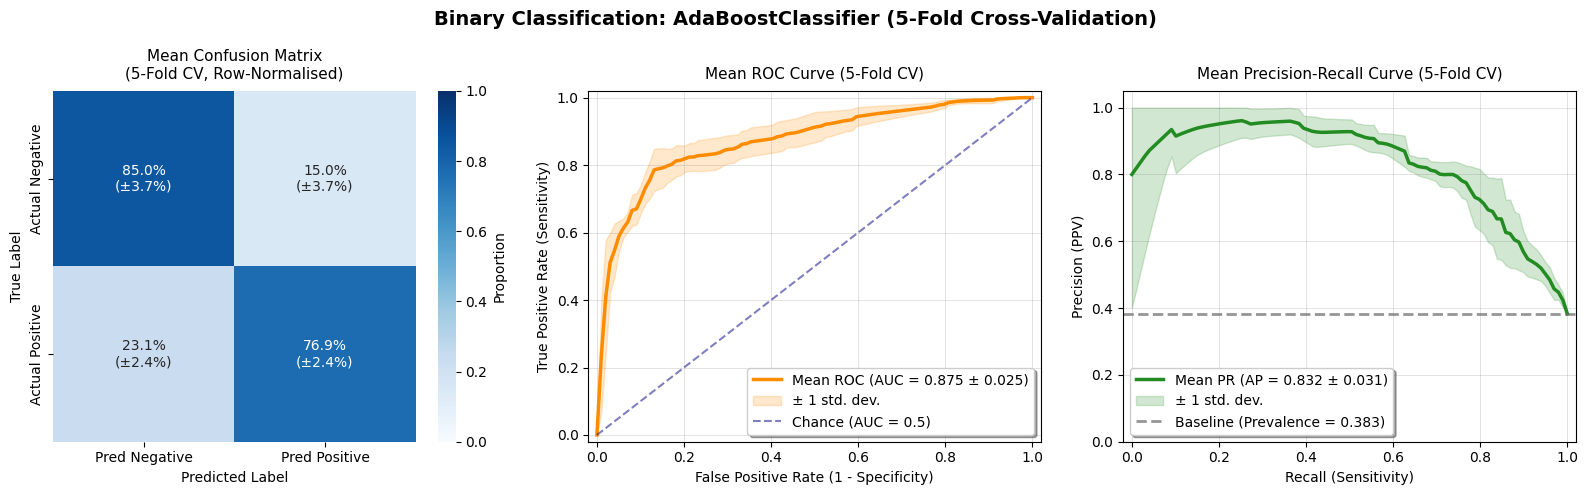

In [40]:
ensemble_candidates = {
	"HGB": make_model_pipeline(
		model=HistGradientBoostingClassifier(random_state=42),
		cat_cols=cat_cols,
		num_cols=num_cols,
		scale_numeric=False,
	),
	"RF": make_model_pipeline(
		model=RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42),
		cat_cols=cat_cols,
		num_cols=num_cols,
		scale_numeric=False,
	),
	"ADA": make_model_pipeline(
		model=AdaBoostClassifier(random_state=42),
		cat_cols=cat_cols,
		num_cols=num_cols,
		scale_numeric=False,
	),
}

evaluation_ensemble = evaluate_candidates(
	candidates=ensemble_candidates,
	X=X_train,
	y=y_train,
	n_splits=5,
	n_jobs=-1,
)

display(evaluation_ensemble)
for model in ensemble_candidates.values():
	classification_evaluation(X=X_train, y=y_train, estimator=model, cv=5, random_state=42)

### 2) `XGBClassifier`, `LightGBM`, `CatBoost`

In [ ]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

Evaluating XGB...
Evaluating LGBM...
Evaluating CAT...


,Model,test_accuracy (mean),test_accuracy (std),test_f1 (mean),test_f1 (std),test_roc_auc (mean),test_roc_auc (std)
0,LGBM,0.818871,0.027479,0.756090,0.028429,0.879802,0.021505
1,CAT,0.818852,0.035728,0.753322,0.042400,0.878604,0.027038
2,XGB,0.814646,0.038149,0.750573,0.041694,0.877029,0.017303


Unknown categories found in columns [3] will be encoded as zeros.


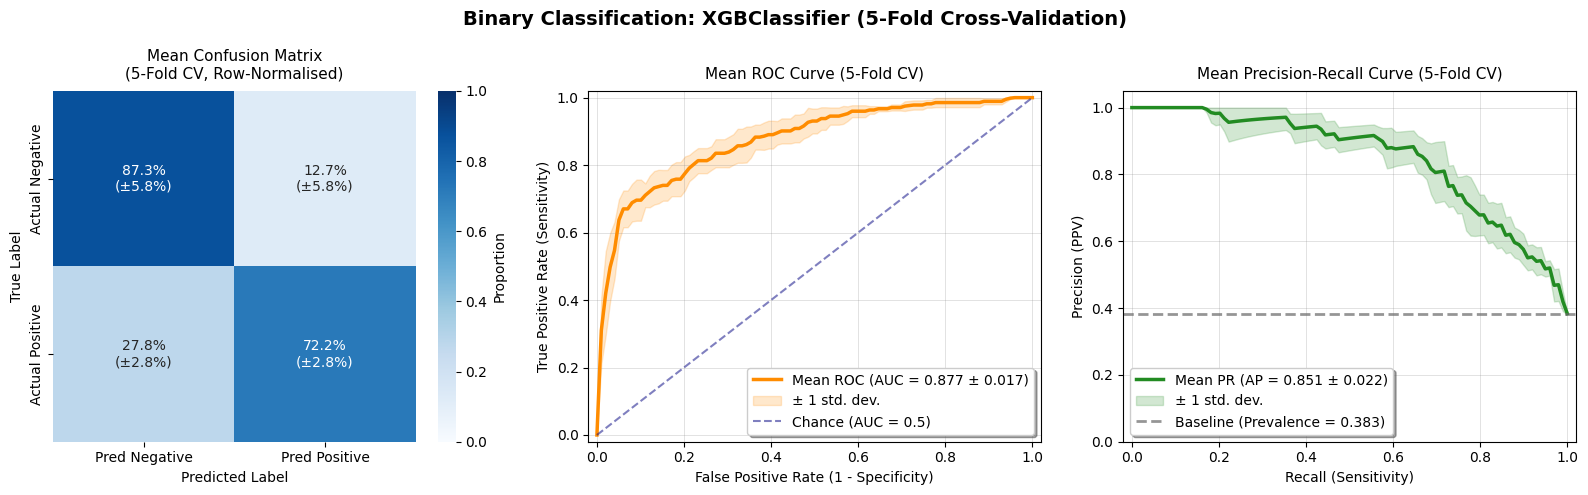

Unknown categories found in columns [3] will be encoded as zeros.


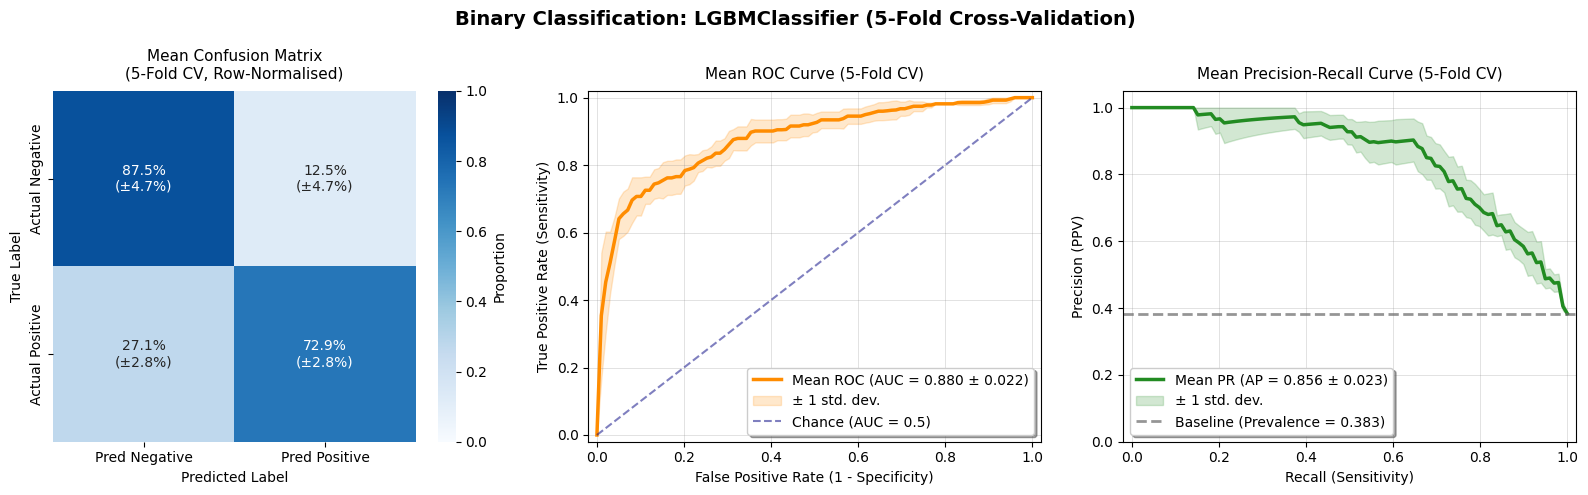

Unknown categories found in columns [3] will be encoded as zeros.


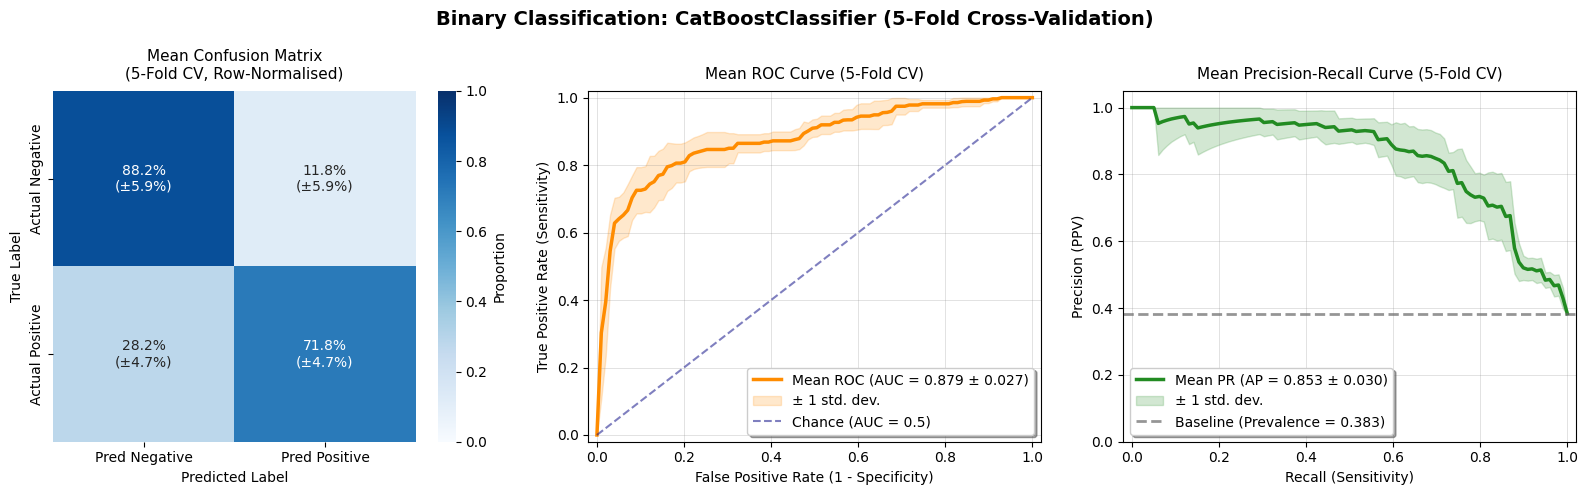

In [49]:
boost_candidates = {
	"XGB": make_model_pipeline(
		model=XGBClassifier(n_estimators=100, learning_rate=0.1, n_jobs=-1, random_state=42),
		cat_cols=cat_cols,
		num_cols=num_cols,
		scale_numeric=False,
	),
	"LGBM": make_model_pipeline(
		model=LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=42, verbose=-1,),
		cat_cols=cat_cols,
		num_cols=num_cols,
		scale_numeric=False,
	),
	"CAT": make_model_pipeline(
		model=CatBoostClassifier(iterations=100, learning_rate=0.1, random_state=42, verbose=0),
		cat_cols=cat_cols,
		num_cols=num_cols,
		scale_numeric=False,
	),
}

evaluation_boost = evaluate_candidates(
	candidates=boost_candidates,
	X=X_train,
	y=y_train,
	n_splits=5,
	n_jobs=-1,
)

display(evaluation_boost)
for model in boost_candidates.values():
	classification_evaluation(X=X_train, y=y_train, estimator=model, cv=5, random_state=42)